(256, 256, 128, 1)


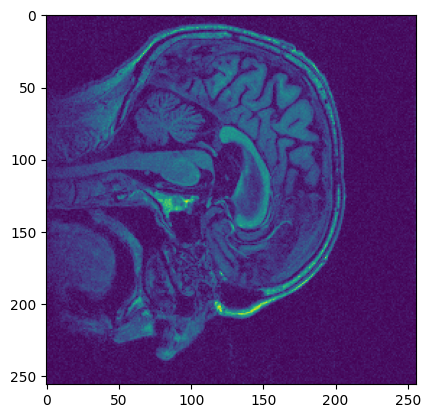

In [22]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

adni_file_name = '../oasis_2_flat_dataset/OAS2_0001_MR1.nifti.img'
test_load = nib.load(adni_file_name).get_fdata()
print(test_load.shape)

#this will plot full siz size 
plt.imshow(test_load[:,:,test_load.shape[2]//2])
plt.show()

In [20]:
import os
import shutil

data_map = {}
# Define the root directory containing the subdirectories
root_dir = "../OAS2_RAW_PART1/OAS2_RAW_PART1"
destination_dir = "../oasis_2_flat_dataset/"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)
all_images = []

# Traverse the directory structure
for dir1 in os.listdir(root_dir):
    dir1_path = os.path.join(root_dir, dir1)
    # dir1 -> refers to MRI ID
    data_map[dir1] = {}
    raw_dir_path = os.path.join(dir1_path, "RAW/")
    image_path = os.path.join(raw_dir_path, "mpr-1.nifti.hdr")
    new_path = os.path.join(destination_dir, f"{dir1}.nifti.hdr")
    shutil.copy(image_path, new_path)
    print(f"Copied: {image_path} → {new_path}")

Copied: ../OAS2_RAW_PART1/OAS2_RAW_PART1/OAS2_0041_MR2/RAW/mpr-1.nifti.hdr → ../oasis_2_flat_dataset/OAS2_0041_MR2.nifti.hdr
Copied: ../OAS2_RAW_PART1/OAS2_RAW_PART1/OAS2_0058_MR3/RAW/mpr-1.nifti.hdr → ../oasis_2_flat_dataset/OAS2_0058_MR3.nifti.hdr
Copied: ../OAS2_RAW_PART1/OAS2_RAW_PART1/OAS2_0090_MR1/RAW/mpr-1.nifti.hdr → ../oasis_2_flat_dataset/OAS2_0090_MR1.nifti.hdr
Copied: ../OAS2_RAW_PART1/OAS2_RAW_PART1/OAS2_0018_MR3/RAW/mpr-1.nifti.hdr → ../oasis_2_flat_dataset/OAS2_0018_MR3.nifti.hdr
Copied: ../OAS2_RAW_PART1/OAS2_RAW_PART1/OAS2_0053_MR2/RAW/mpr-1.nifti.hdr → ../oasis_2_flat_dataset/OAS2_0053_MR2.nifti.hdr
Copied: ../OAS2_RAW_PART1/OAS2_RAW_PART1/OAS2_0058_MR1/RAW/mpr-1.nifti.hdr → ../oasis_2_flat_dataset/OAS2_0058_MR1.nifti.hdr
Copied: ../OAS2_RAW_PART1/OAS2_RAW_PART1/OAS2_0088_MR2/RAW/mpr-1.nifti.hdr → ../oasis_2_flat_dataset/OAS2_0088_MR2.nifti.hdr
Copied: ../OAS2_RAW_PART1/OAS2_RAW_PART1/OAS2_0014_MR2/RAW/mpr-1.nifti.hdr → ../oasis_2_flat_dataset/OAS2_0014_MR2.nifti.hdr


## Create preprocessed dataset

In [17]:
import os
import nibabel as nib
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from skimage import io, exposure
from skimage.filters import unsharp_mask
from skimage.restoration import denoise_bilateral

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input and output directories
input_dir = "../oasis_2_flat_dataset"
output_dir = "oasis2_preprocessed_images"
os.makedirs(output_dir, exist_ok=True)

def preprocess_image(nifti_file):
    """
    Preprocess a single NIfTI file:
    - Contrast enhancement
    - Sharpening
    - Noise reduction
    - Edge detection + Contour-based cropping
    """
    # Load NIfTI file
    img_data = nib.load(nifti_file).get_fdata()

    # Normalize intensities to [0, 1]
    normalized_img = (img_data - img_data.min()) / (img_data.max() - img_data.min())

    # Extract the middle axial slice
    middle_slice = torch.tensor(normalized_img[:, :, normalized_img.shape[2] // 2]).to(device)

    # Contrast Enhancement
    p2, p98 = np.percentile(middle_slice.cpu().numpy(), (2, 98))
    contrast_enhanced = exposure.rescale_intensity(middle_slice.cpu().numpy(), in_range=(p2, p98))

    # Sharpening using Unsharp Masking
    sharpened_image = unsharp_mask(contrast_enhanced, radius=1.5, amount=1.5)

    if sharpened_image.ndim == 3 and sharpened_image.shape[-1] == 1:
        sharpened_image = np.squeeze(sharpened_image, axis=-1)
    
    # Noise Reduction using Bilateral Filtering (Preserves Edges)
    denoised_image = denoise_bilateral(sharpened_image, sigma_color=0.05, sigma_spatial=15, channel_axis=None)

    # Convert to uint8 format for OpenCV processing
    denoised_uint8 = (denoised_image * 255).astype(np.uint8)

    # Canny Edge Detection
    edges = cv2.Canny(denoised_uint8, threshold1=50, threshold2=150)

    # Morphological Closing to Fill Gaps in the Edges
    kernel = np.ones((5, 5), np.uint8)
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Contour-Based Cropping
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assumed to be the brain/skull)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = denoised_image[y:y+h, x:x+w]
    else:
        cropped_image = denoised_image  # Default to original if no contour found

    return cropped_image

In [18]:
# Process all NIfTI files in the input folder
for file in os.listdir(input_dir):
    if file.endswith(".nifti.img"):  # Ensure only NIfTI files are processed
        nifti_path = os.path.join(input_dir, file)

        # Preprocess the image
        processed_img = preprocess_image(nifti_path)

        # Save the preprocessed image
        output_path = os.path.join(output_dir, file.replace(".nifti.img", ".png"))
        Image.fromarray((processed_img * 255).astype(np.uint8)).save(output_path)

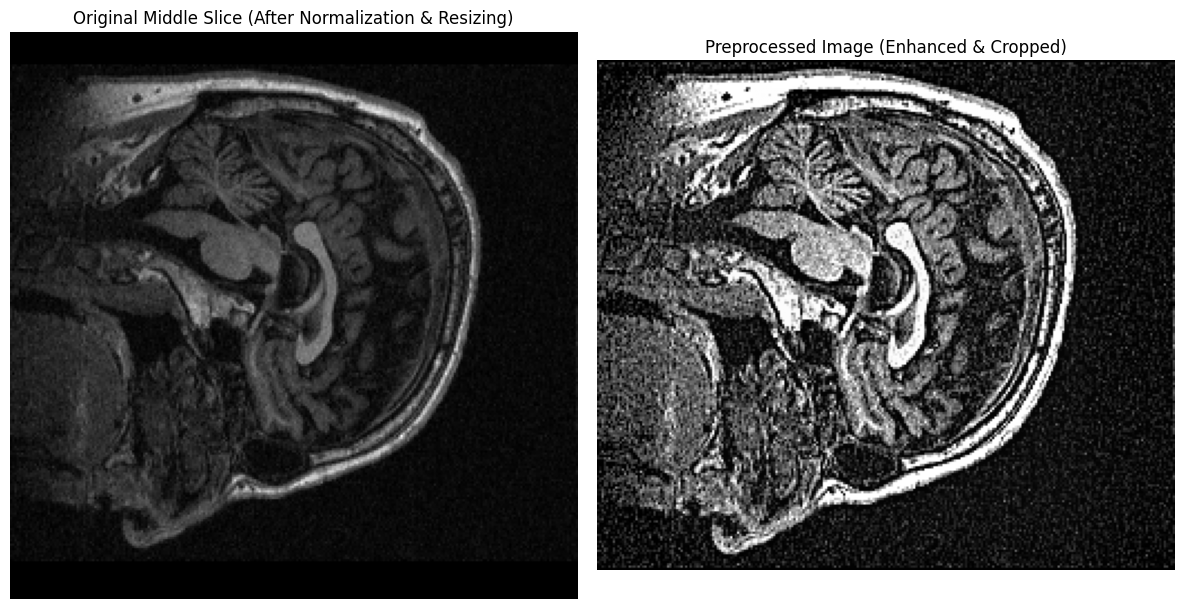

Preprocessed images saved to oasis2_preprocessed_images


In [19]:
# Display a before and after comparison for one sample
sample_file = os.path.join(input_dir, os.listdir(input_dir)[0])
original_img_data = nib.load(sample_file).get_fdata()
original_middle_slice = (original_img_data[:, :, original_img_data.shape[2] // 2] - original_img_data.min()) / (original_img_data.max() - original_img_data.min())
processed_img = preprocess_image(sample_file)

# Plot the original middle slice and preprocessed image
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_middle_slice, cmap="gray")
axs[0].set_title("Original Middle Slice (After Normalization & Resizing)")
axs[0].axis("off")

axs[1].imshow(processed_img, cmap="gray")
axs[1].set_title("Preprocessed Image (Enhanced & Cropped)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

print(f"Preprocessed images saved to {output_dir}")